In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import *
from sklearn.utils import check_array
from sklearn.metrics import *

In [2]:
import numpy as np

from scipy.special import gamma,psi
from scipy import ndimage
from scipy.linalg import det
from numpy import pi

from sklearn.neighbors import NearestNeighbors

__all__=['entropy', 'mutual_information', 'entropy_gaussian']

EPS = np.finfo(float).eps

In [3]:
def mutual_information_2d(x, y, sigma=1, normalized=False):
    """
    Computes (normalized) mutual information between two 1D variate from a
    joint histogram.
    Parameters
    ----------
    x : 1D array
        first variable
    y : 1D array
        second variable
    sigma: float
        sigma for Gaussian smoothing of the joint histogram
    Returns
    -------
    nmi: float
        the computed similariy measure
    """
    bins = (256, 256)

    jh = np.histogram2d(x, y, bins=bins)[0]

    # smooth the jh with a gaussian filter of given sigma
    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                 output=jh)

    # compute marginal histograms
    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    # Normalised Mutual Information of:
    # Studholme,  jhill & jhawkes (1998).
    # "A normalized entropy measure of 3-D medical image alignment".
    # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
                / np.sum(jh * np.log(jh))) - 1
    else:
        mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
               - np.sum(s2 * np.log(s2)))

    return mi

In [4]:
meterdata = pd.read_csv('lib/data/household_power_consumption.txt', 
                        delimiter=';', 
                        skiprows=1,
                        names=['date','time','global_active_power','global_reactive_power','voltage'
                               ,'global_intensity', 'sub_metering_1','sub_metering_2','sub_metering_3'],
                        nrows=200000,
                        parse_dates=[['date','time'],'date'],
                        keep_date_col=True,
#                         index_col='date_time',
                        na_values=['?'],
                        dtype={'global_active_power':np.float64})
meterdata.head()

,date_time,date,time,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
0,2006-12-16 17:24:00,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
meterdata.describe()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
count,196268.000000,196268.000000,196268.000000,196268.000000,196268.000000,196268.000000,196268.000000
mean,1.352544,0.121191,240.345123,5.733341,1.224051,1.733966,6.443735
std,1.280684,0.111671,3.361217,5.402444,6.464399,7.021726,8.428507
min,0.104000,0.000000,223.490000,0.400000,0.000000,0.000000,0.000000
25%,0.314000,0.000000,238.260000,1.400000,0.000000,0.000000,0.000000
50%,1.072000,0.106000,240.600000,4.800000,0.000000,0.000000,0.000000
75%,1.992500,0.188000,242.640000,8.400000,0.000000,1.000000,17.000000
max,10.670000,0.874000,251.700000,46.400000,77.000000,78.000000,20.000000


In [6]:
meterdata.date.describe()

count                  200000
unique                    140
top       2007-03-13 00:00:00
freq                     1440
first     2006-12-16 00:00:00
last      2007-12-04 00:00:00
Name: date, dtype: object

In [7]:
meterdata.date_time.describe()

count                  200000
unique                 200000
top       2006-12-24 01:48:00
freq                        1
first     2006-12-16 17:24:00
last      2007-12-04 23:59:00
Name: date_time, dtype: object

In [8]:
meterdata.time.describe()

count       200000
unique        1440
top       01:21:00
freq           139
Name: time, dtype: object

In [9]:
print("Checking if Null values exist:")
print(meterdata.isnull().any())

Checking if Null values exist:
date_time                False
date                     False
time                     False
global_active_power       True
global_reactive_power     True
voltage                   True
global_intensity          True
sub_metering_1            True
sub_metering_2            True
sub_metering_3            True
dtype: bool


In [10]:
meterdata2 = meterdata.fillna(method='ffill')
meterdata2.describe()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000
mean,1.336588,0.122810,240.268614,5.667832,1.20159,1.701800,6.324010
std,1.274120,0.111251,3.375717,5.373571,6.40700,6.960074,8.395047
min,0.104000,0.000000,223.490000,0.400000,0.00000,0.000000,0.000000
25%,0.316000,0.000000,238.090000,1.400000,0.00000,0.000000,0.000000
50%,0.954000,0.108000,240.530000,4.200000,0.00000,0.000000,0.000000
75%,1.960000,0.196000,242.600000,8.200000,0.00000,1.000000,17.000000
max,10.670000,0.874000,251.700000,46.400000,77.00000,78.000000,20.000000


In [11]:
meterdata2.groupby('date').global_active_power.agg(['sum','count'])

,sum,count
date,,
2006-12-16,1209.176,396
2006-12-17,3390.460,1440
2006-12-18,2203.826,1440
2006-12-19,1666.194,1440
2006-12-20,2225.748,1440
...,...,...
2007-11-04,887.482,1440
2007-12-01,1461.296,1440
2007-12-02,1877.610,1440


In [12]:
unq_dates = np.unique(meterdata2.date)
unq_dates = unq_dates[2:unq_dates.shape[0]-1]
# unq_dates

In [13]:
# final_meter = meterdata2[meterdata2.date.isin([np.random.choice(unq_dates)])].copy() # Random single date
final_meter = meterdata2[meterdata2.date.isin(unq_dates)].copy() # Whole data
# final_meter = meterdata2[meterdata2.date.dt.month==1].copy() # One month
final_meter.groupby('date').global_active_power.agg(num_rows='count',global_active_power='sum')

,num_rows,global_active_power
date,,
2006-12-18,1440,2203.826
2006-12-19,1440,1666.194
2006-12-20,1440,2225.748
2006-12-21,1440,1717.112
2006-12-22,1440,2341.338
...,...,...
2007-11-03,1440,3480.636
2007-11-04,1440,887.482
2007-12-01,1440,1461.296


In [14]:
final_meter.head()

,date_time,date,time,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
1836,2006-12-18 00:00:00,2006-12-18,00:00:00,0.278,0.126,246.17,1.2,0.0,2.0,0.0
1837,2006-12-18 00:01:00,2006-12-18,00:01:00,0.238,0.056,246.40,1.0,0.0,0.0,0.0
1838,2006-12-18 00:02:00,2006-12-18,00:02:00,0.208,0.000,246.46,0.8,0.0,0.0,0.0
1839,2006-12-18 00:03:00,2006-12-18,00:03:00,0.206,0.000,245.94,0.8,0.0,0.0,0.0
1840,2006-12-18 00:04:00,2006-12-18,00:04:00,0.206,0.000,245.98,0.8,0.0,0.0,0.0


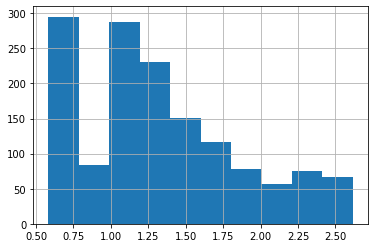

In [15]:
final_meter.groupby('time').global_active_power.mean().hist()

In [16]:
def uniform_noise(day_data, perc_change=2):
#     perc_change = 10
    max_change = day_data.sum()/100*perc_change
    total_size = day_data.shape[0]
    cdf_val = norm.ppf(0.98)
    std = max_change/cdf_val
    uniform_limit = np.sqrt(3*std**2/total_size)
    noise = np.random.uniform(-uniform_limit, uniform_limit, total_size)
    perturbed_data = day_data + noise
    return perturbed_data

def mapd(true_data, pert_data):
    return np.mean(np.abs((true_data - pert_data) / true_data))

def evaluate(true_data, pert_data):
    mse = mean_squared_error(true_data, pert_data)
    print("MSE: ",mse)
    print("Correlation coefficient: ", true_data.corr(pert_data))
    print("Mutual information: ",mutual_information_2d(true_data, pert_data))

MAPD:  16.630329761039597
MSE:  183.7336602150986
Correlation coefficient:  0.0907831605659467
Mutual information:  0.06330507044915468


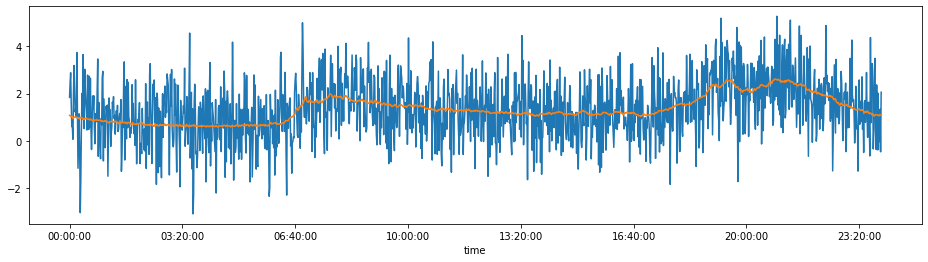

In [17]:
date_grouped = final_meter.groupby('date')['global_active_power']
perturbed_data = date_grouped.apply(uniform_noise, (50))
final_meter['uniform_day_active'] = perturbed_data
print("MAPD: ",mapd(final_meter['global_active_power'],final_meter['uniform_day_active']))
print("MSE: ",mean_squared_error(final_meter['global_active_power'],final_meter['uniform_day_active']))
print("Correlation coefficient: ",final_meter['global_active_power'].corr(final_meter['uniform_day_active']))
print("Mutual information: ",mutual_information_2d(final_meter['global_active_power'],
                                                   final_meter['uniform_day_active']))
# fig, ax = plt.subplots(2,figsize=(16,4))
plt.figure(figsize=(16,4))
final_meter.groupby('time').uniform_day_active.mean().plot()
final_meter.groupby('time').global_active_power.mean().plot()

MSE:  206.91599497662736
Correlation coefficient:  0.08490852964251161
Mutual information:  0.04345556213056412


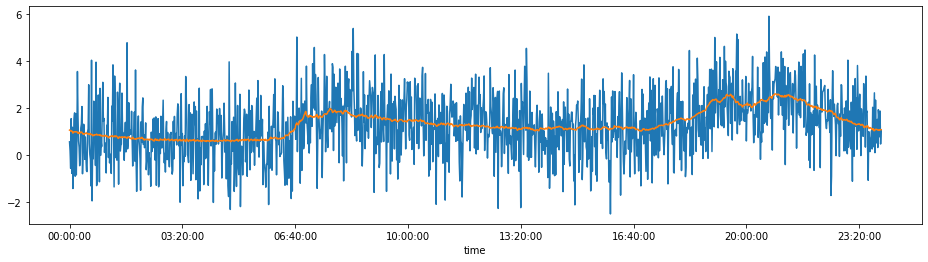

In [18]:
final_meter['uniform_active'] = uniform_noise(final_meter.global_active_power,5)
evaluate(final_meter['global_active_power'],final_meter['uniform_active'])

plt.figure(figsize=(16,4))

final_meter.groupby('time').uniform_active.mean().plot()
final_meter.groupby('time').global_active_power.mean().plot()

In [19]:
final_meter[['global_active_power','uniform_day_active','uniform_active']].agg(['mean','sum'])

,global_active_power,uniform_day_active,uniform_active
mean,1.332731,1.341817,1.291202
sum,262180.172000,263967.546746,254010.437854


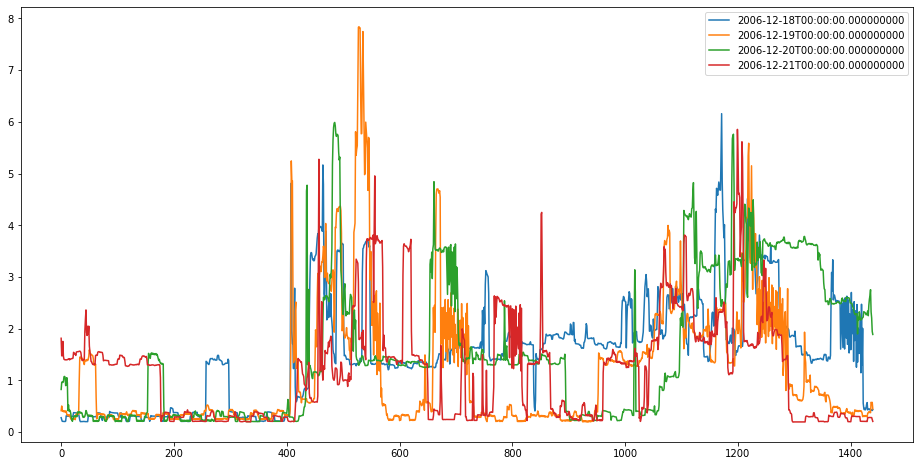

In [62]:
plt.figure(figsize=(16,8))
i=0
for date, power in date_grouped:
#     print(power.shape)
    plt.plot(range(power.shape[0]),power)
    if i>2 : break
    i += 1
plt.legend(unq_dates)
plt.show()

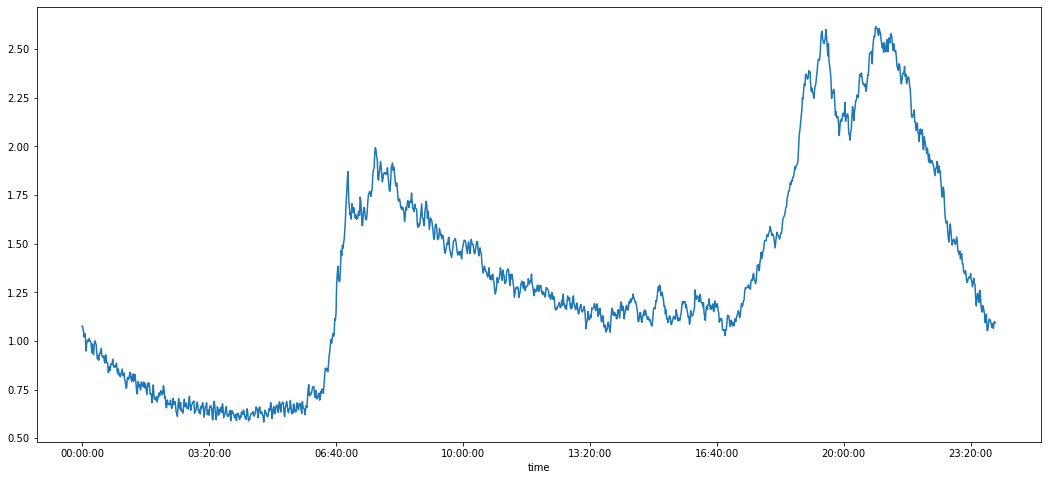

In [63]:
plt.figure(figsize=(18,8))
final_meter.groupby('time').global_active_power.mean().plot()

In [403]:
max_change = final_meter.global_active_power.sum()/100*5
total_size = final_meter.shape[0]
max_change, total_size

(13016.1845, 196724)

In [404]:
cdf_val = norm.ppf(0.98)
std = max_change/cdf_val
uniform_limit = np.sqrt(3*std**2/total_size)
std, uniform_limit

(6337.7681821852575, 24.749606823706493)

In [405]:
noise = np.random.uniform(-uniform_limit, uniform_limit, total_size)
print(noise.sum(), noise.mean(), noise.shape)
final_meter['new_active'] = final_meter['global_active_power'] + noise

-7032.839699174888 -0.03574977989048051 (196724,)


In [406]:
print("MSE: ",mean_squared_error(final_meter['global_active_power'],final_meter['new_active']))
print("Correlation coefficient: ",final_meter['global_active_power'].corr(final_meter['new_active']))
print("Mutual information: ",mutual_information_2d(final_meter['global_active_power'],final_meter['new_active']))

MSE:  203.87554343653773
Correlation coefficient:  0.0919746240296424
Mutual information:  0.04443964588701821


In [407]:
print("MSE: ",mean_squared_error(final_meter['global_active_power'],final_meter['new_active']))
print("Correlation coefficient: ",final_meter['global_active_power'].corr(final_meter['new_active']))
print("Mutual information: ",mutual_information_2d(final_meter['global_active_power'],final_meter['new_active']))

MSE:  203.87554343653773
Correlation coefficient:  0.0919746240296424
Mutual information:  0.04443964588701821


In [408]:
print("MSE: ",mean_squared_error(final_meter['global_active_power'],final_meter['new_active']))
print("Correlation coefficient: ",final_meter['global_active_power'].corr(final_meter['new_active']))
print("Mutual information: ",mutual_information_2d(final_meter['global_active_power'],final_meter['new_active']))

MSE:  203.87554343653773
Correlation coefficient:  0.0919746240296424
Mutual information:  0.04443964588701821


In [409]:
mutual_information_2d(final_meter['global_active_power'],final_meter['new_active'])

0.04443964588701821

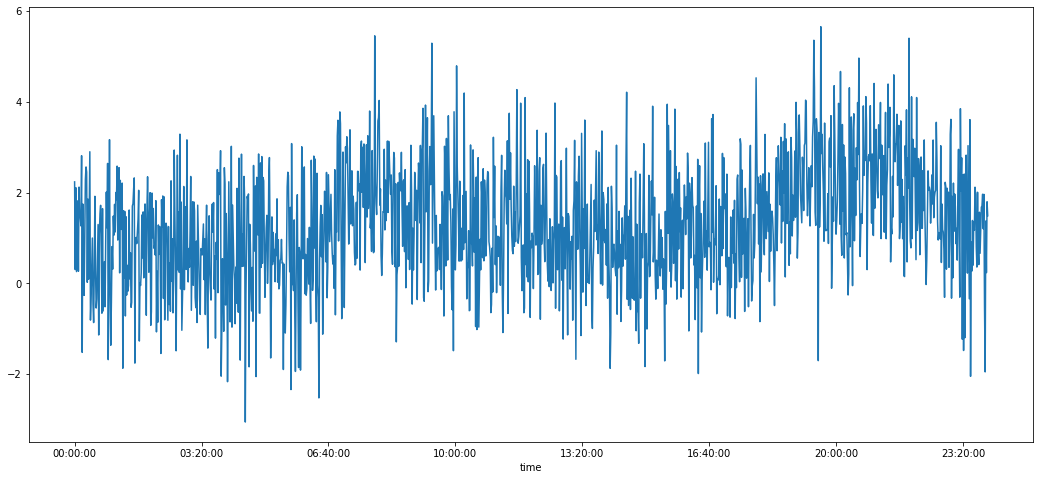

In [410]:
plt.figure(figsize=(18,8))
final_meter.groupby('time').new_active.mean().plot()

In [348]:
final_meter[['global_active_power','new_active','uniform_active']].agg(['mean','sum'])

,global_active_power,new_active,uniform_active
mean,1.411057,1.410347,1.414424
sum,6095.768000,6092.697961,6110.313195


In [234]:
gauss_noise = np.random.normal(0, std, total_size)
print(gauss_noise.sum(), gauss_noise.mean(), gauss_noise.shape)
final_meter['gauss_active'] = final_meter['global_active_power'] + gauss_noise

1692608.685781736 8.603976565044102 (196724,)


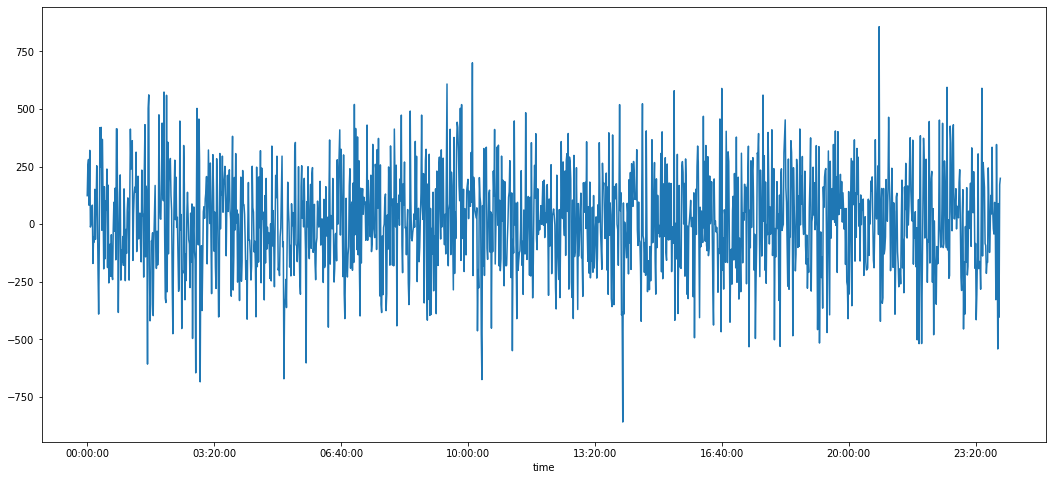

In [235]:
plt.figure(figsize=(18,8))
final_meter.groupby('time').gauss_active.mean().plot()

In [236]:
final_meter[['global_active_power','new_active','gauss_active']].agg(['mean','sum'])

,global_active_power,new_active,gauss_active
mean,1.323294,1.324671,9.927271e+00
sum,260323.690000,260594.538958,1.952932e+06


In [ ]:
def uniform_noise(day_data):
    perc_change = 2
    max_change = day_data.global_active_power.sum()/100*perc_change
    total_size = day_data.shape[0]
    cdf_val = norm.ppf(0.98)
    std = max_change/cdf_val
    uniform_limit = np.sqrt(3*std**2/total_size)
    noise = np.random.uniform(-uniform_limit, uniform_limit, total_size)
    final_meter['uniform_active'] = final_meter['uniform_active'] + noise

In [261]:
final_meter['uniform_active'] = np.zeros(final_meter.shape[0])

In [262]:
final_meter

,date_time,date,time,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,new_active,gauss_active,uniform_active
1836,2006-12-18 00:00:00,2006-12-18,00:00:00,0.278,0.126,246.17,1.2,0.0,2.0,0.0,-3.684966,2303.008581,0.0
1837,2006-12-18 00:01:00,2006-12-18,00:01:00,0.238,0.056,246.40,1.0,0.0,0.0,0.0,4.051989,3997.039704,0.0
1838,2006-12-18 00:02:00,2006-12-18,00:02:00,0.208,0.000,246.46,0.8,0.0,0.0,0.0,-4.599232,1790.836024,0.0
1839,2006-12-18 00:03:00,2006-12-18,00:03:00,0.206,0.000,245.94,0.8,0.0,0.0,0.0,4.391471,-1165.789657,0.0
1840,2006-12-18 00:04:00,2006-12-18,00:04:00,0.206,0.000,245.98,0.8,0.0,0.0,0.0,-1.292360,1576.940875,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2007-04-05 14:39:00,2007-04-05,14:39:00,0.348,0.120,235.48,1.6,0.0,0.0,0.0,-2.261663,3958.163285,0.0
199996,2007-04-05 14:40:00,2007-04-05,14:40:00,0.344,0.118,234.92,1.6,0.0,0.0,0.0,-2.778502,-1390.562403,0.0
199997,2007-04-05 14:41:00,2007-04-05,14:41:00,0.342,0.118,234.41,1.6,0.0,0.0,0.0,-0.105745,1652.208614,0.0
199998,2007-04-05 14:42:00,2007-04-05,14:42:00,0.340,0.114,233.88,1.6,0.0,0.0,0.0,0.089667,2550.365626,0.0
